Gathering Data

In [124]:
import pandas as pd
import requests

# Fetch the data.
df = pd.read_csv("https://ourworldindata.org/grapher/monthly-co2-emissions-from-international-and-domestic-flights.csv?v=1&csvType=full&useColumnShortNames=true", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})

# Fetch the metadata
metadata = requests.get("https://ourworldindata.org/grapher/monthly-co2-emissions-from-international-and-domestic-flights.metadata.json?v=1&csvType=full&useColumnShortNames=true").json()

In [125]:
df.head(1)

,Entity,Code,Day,ter_dom_m,ter_int_m
0,Afghanistan,AFG,2019-01-15,1576.6334,10899.172


Data Cleaning

In [126]:
df['Day'] = pd.to_datetime(df['Day'])
df

,Entity,Code,Day,ter_dom_m,ter_int_m
0,Afghanistan,AFG,2019-01-15,1576.6334,10899.1720
1,Afghanistan,AFG,2019-02-15,1794.2830,10676.1920
2,Afghanistan,AFG,2019-03-15,1409.3792,10475.1620
3,Afghanistan,AFG,2019-04-15,2558.5806,12447.3580
4,Afghanistan,AFG,2019-05-15,2011.3917,11834.1520
...,...,...,...,...,...
13305,Zimbabwe,ZWE,2023-08-15,NaN,13718.7705
13306,Zimbabwe,ZWE,2023-09-15,NaN,13263.5260
13307,Zimbabwe,ZWE,2023-11-15,NaN,14148.6810
13308,Zimbabwe,ZWE,2024-01-15,NaN,13685.1490


In [127]:
co2 = df[(df['Entity'] == 'World') & (df['Day'] < '2024-01-15')]
co2.head()

,Entity,Code,Day,ter_dom_m,ter_int_m
13062,World,OWID_WRL,2019-01-15,25458934.0,44271290.0
13063,World,OWID_WRL,2019-02-15,23327330.0,39871720.0
13064,World,OWID_WRL,2019-03-15,23483454.0,40737690.0
13065,World,OWID_WRL,2019-04-15,25564624.0,44844636.0
13066,World,OWID_WRL,2019-05-15,26616754.0,46503204.0


In [128]:
co2 = co2.set_index('Day')
co2['total'] = co2['ter_dom_m'] + co2['ter_int_m']
co2.head()

,Entity,Code,ter_dom_m,ter_int_m,total
Day,,,,,
2019-01-15,World,OWID_WRL,25458934.0,44271290.0,69730224.0
2019-02-15,World,OWID_WRL,23327330.0,39871720.0,63199050.0
2019-03-15,World,OWID_WRL,23483454.0,40737690.0,64221144.0
2019-04-15,World,OWID_WRL,25564624.0,44844636.0,70409260.0
2019-05-15,World,OWID_WRL,26616754.0,46503204.0,73119958.0


Data Vizualization

In [129]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=co2.index, y=co2['total'], mode='lines+markers', name='Total CO₂'))

fig.update_layout(title = 'Monthly CO2 Emissions from International and Domestic Flights',
                  xaxis_title = 'Date (Years)',
                  yaxis_title = 'CO2 Emissions (Million Tonnes)',
                  template = 'plotly_dark')

fig.add_vrect(x0="2020-01-01", x1="2020-12-31", 
              fillcolor="red", opacity=0.3, 
              layer="below", line_width=0)

co2['rolling_mean'] = co2['total'].rolling(window=6).mean()
fig.add_trace(go.Scatter(x=co2.index, y=co2['rolling_mean'], mode='lines', name='6-Month Moving Avg'))

fig.show()

ACF Plot

<Figure size 800x500 with 0 Axes>

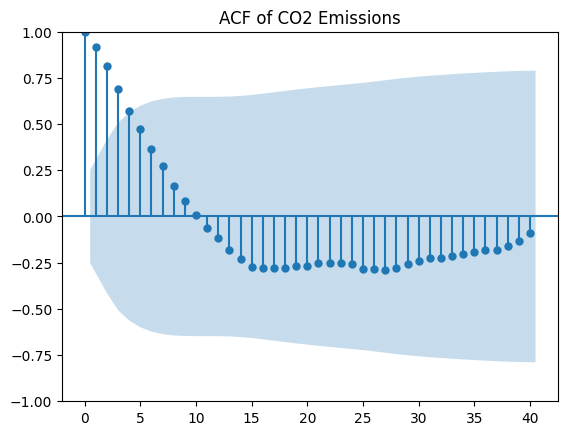

In [84]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Plot ACF of Apple closing prices
plt.figure(figsize=(8, 5))
plot_acf(co2['total'], lags=40)
plt.title("ACF of CO2 Emissions")
plt.show()

Log Transformation (Due to High Spikes from Covid 19)

In [130]:
import numpy as np
co2["log_total"] = np.log(co2["total"])

Decomposition

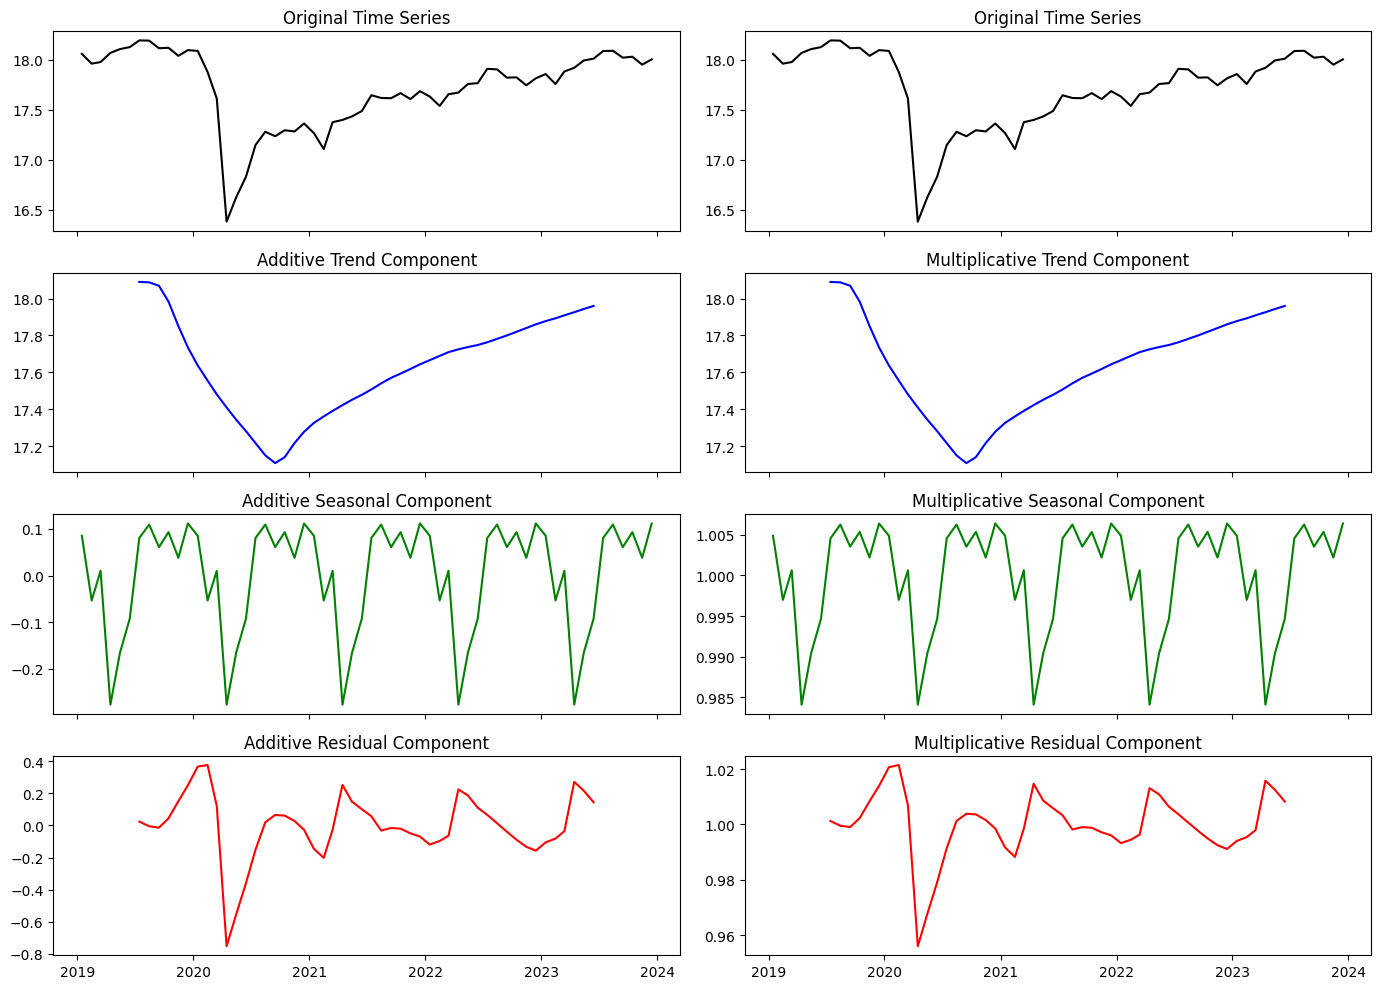

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

# ---  Apply Additive and Multiplicative Decomposition ---
additive_decomposition = seasonal_decompose(co2["log_total"], model="additive", period=12)
multiplicative_decomposition = seasonal_decompose(co2["log_total"], model="multiplicative", period=12)

# Plot both decompositions side by side
fig, axes = plt.subplots(4, 2, figsize=(14, 10), sharex=True)

# Additive Decomposition Plots
axes[0, 0].plot(co2.index, co2["log_total"], color="black")
axes[0, 0].set_title("Original Time Series")

axes[1, 0].plot(co2.index, additive_decomposition.trend, color="blue")
axes[1, 0].set_title("Additive Trend Component")

axes[2, 0].plot(co2.index, additive_decomposition.seasonal, color="green")
axes[2, 0].set_title("Additive Seasonal Component")

axes[3, 0].plot(co2.index, additive_decomposition.resid, color="red")
axes[3, 0].set_title("Additive Residual Component")

# Multiplicative Decomposition Plots
axes[0, 1].plot(co2.index, co2["log_total"], color="black")
axes[0, 1].set_title("Original Time Series")

axes[1, 1].plot(co2.index, multiplicative_decomposition.trend, color="blue")
axes[1, 1].set_title("Multiplicative Trend Component")

axes[2, 1].plot(co2.index, multiplicative_decomposition.seasonal, color="green")
axes[2, 1].set_title("Multiplicative Seasonal Component")

axes[3, 1].plot(co2.index, multiplicative_decomposition.resid, color="red")
axes[3, 1].set_title("Multiplicative Residual Component")

plt.tight_layout()
plt.show()

ADF Test (Both "Add" & "Mul" Work. "Add" for Interpretation) 

In [88]:
# --- Perform ADF Test on Residuals (Assuming Additive is Best) ---
residuals = additive_decomposition.resid.dropna()
adf_result = adfuller(residuals)

print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")

ADF Statistic: -4.5171
p-value: 0.0002


ACF & PACF if Residuals

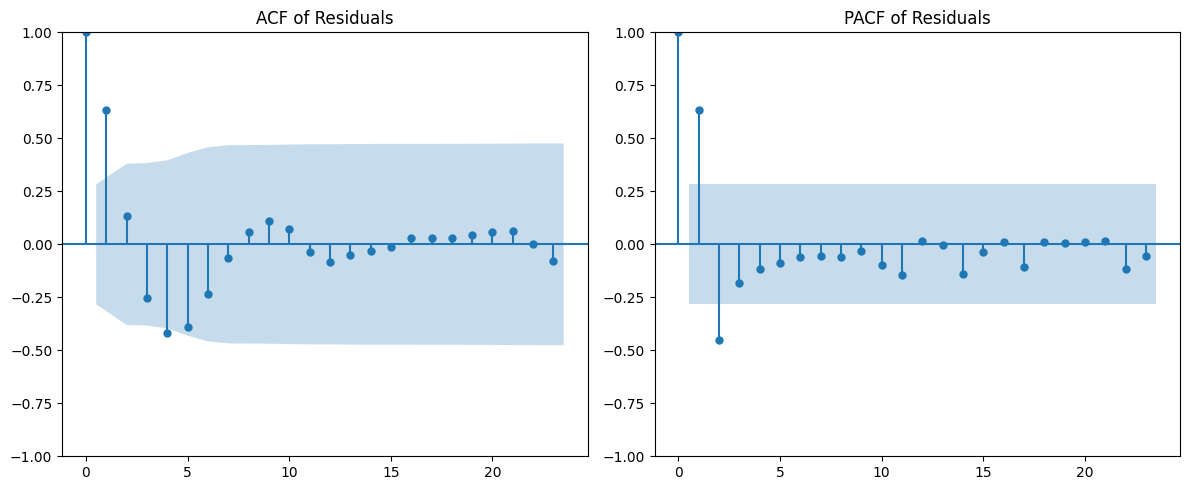

In [89]:
# ---  ACF and PACF Plots of Residuals ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ACF plot
plot_acf(residuals, lags=23, ax=axes[0])
axes[0].set_title("ACF of Residuals")

# PACF plot
plot_pacf(residuals, lags=23, ax=axes[1])
axes[1].set_title("PACF of Residuals")

plt.tight_layout()
plt.show()

Model Evaluation

In [91]:
from statsmodels.tsa.arima.model import ARIMA

arma_22 = ARIMA(co2['log_total'], order=(2, 0, 2)).fit()

# 1. ARMA(1,1)
arma_11 = ARIMA(co2['log_total'], order=(1, 0, 1)).fit()

# 2. ARMA(2,1)
arma_21 = ARIMA(co2['log_total'], order=(2, 0, 1)).fit()

# 3. ARMA(1,2)
arma_12 = ARIMA(co2['log_total'], order=(1, 0, 2)).fit()

arma_32 = ARIMA(co2['log_total'], order=(3, 0, 2)).fit()

# Print summaries
print("ARMA(2,2) AIC:", arma_22.aic, "BIC:", arma_22.bic)
print("ARMA(1,1) AIC:", arma_11.aic, "BIC:", arma_11.bic)
print("ARMA(2,1) AIC:", arma_21.aic, "BIC:", arma_21.bic)
print("ARMA(1,2) AIC:", arma_12.aic, "BIC:", arma_12.bic)
print("ARMA(3,2) AIC:", arma_32.aic, "BIC:", arma_32.bic)

ARMA(2,2) AIC: -20.85085434291497 BIC: -8.28478696958237
ARMA(1,1) AIC: -23.3406119890074 BIC: -14.963233740118998
ARMA(2,1) AIC: -21.76750889171185 BIC: -11.295786080601346
ARMA(1,2) AIC: -22.78704434147169 BIC: -12.315321530361189
ARMA(3,2) AIC: -22.80428524226086 BIC: -8.143873306706158


ARMA(1, 0, 1) Lowest BIC & AIC

In [92]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# Fit ARMA(2,2)
arma_model = ARIMA(co2['log_total'], order=(1, 0, 1))  # Using the original total emissions data
arma_fit = arma_model.fit()

# Print Model Summary
print(arma_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              log_total   No. Observations:                   60
Model:                 ARIMA(1, 0, 1)   Log Likelihood                  15.670
Date:                Mon, 03 Mar 2025   AIC                            -23.341
Time:                        20:16:44   BIC                            -14.963
Sample:                             0   HQIC                           -20.064
                                 - 60                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.7617      0.313     56.688      0.000      17.148      18.376
ar.L1          0.8417      0.166      5.064      0.000       0.516       1.167
ma.L1          0.1360      0.239      0.570      0.5

AR(1, 0) Simpler AR Model Lowest BIC / AIC (Best Choice)

In [93]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARMA(1,0)
arma_10 = ARIMA(co2['log_total'], order=(1, 0, 0)).fit()

# Print summary
print(arma_10.summary())

                               SARIMAX Results                                
Dep. Variable:              log_total   No. Observations:                   60
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  15.127
Date:                Mon, 03 Mar 2025   AIC                            -24.254
Time:                        20:16:44   BIC                            -17.971
Sample:                             0   HQIC                           -21.796
                                 - 60                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.7701      0.343     51.800      0.000      17.098      18.442
ar.L1          0.8719      0.119      7.327      0.000       0.639       1.105
sigma2         0.0345      0.003     12.607      0.0

Residual Analysis

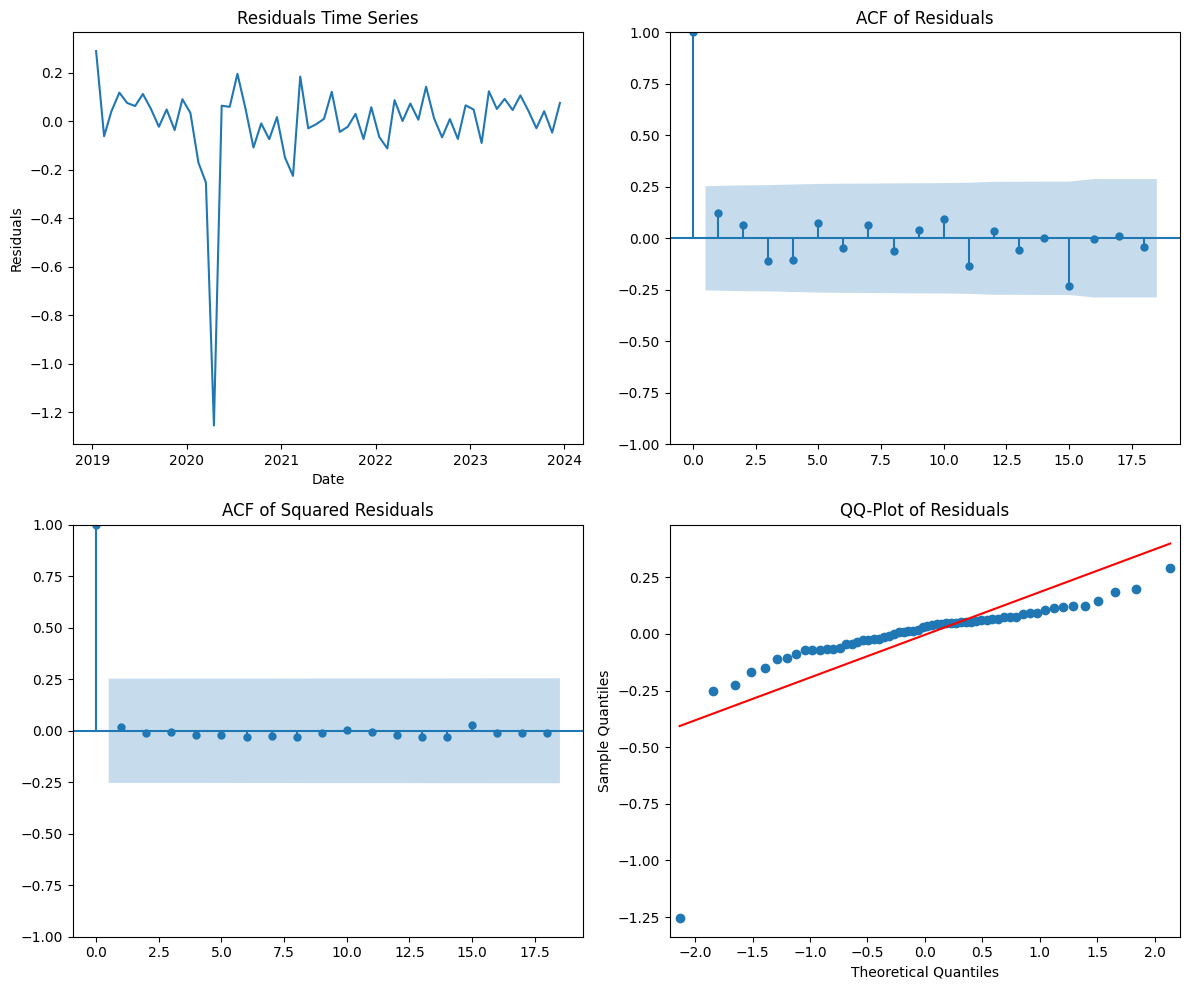

In [94]:
import statsmodels.api as sm

# Fit an AR(1) model (for example) and obtain residuals
model = ARIMA(co2['log_total'], order=(1, 0, 0))
results = model.fit()
resid = results.resid

# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Time series plot of the residuals
axes[0, 0].plot(resid)
axes[0, 0].set_title("Residuals Time Series")
axes[0, 0].set_xlabel("Date")
axes[0, 0].set_ylabel("Residuals")

# 2. ACF plot of the residuals
plot_acf(resid, ax=axes[0, 1])
axes[0, 1].set_title("ACF of Residuals")

# 3. ACF plot of the squared residuals
plot_acf(resid**2, ax=axes[1, 0])
axes[1, 0].set_title("ACF of Squared Residuals")

# 4. QQ-plot of the residuals
sm.qqplot(resid, line='s', ax=axes[1, 1])
axes[1, 1].set_title("QQ-Plot of Residuals")

plt.tight_layout()
plt.show()

SARIMA for fun

In [95]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define SARIMA Model (Using Seasonal Component)
sarima_model = SARIMAX(co2['log_total'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 12)).fit()

# Print summary
print(sarima_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          log_total   No. Observations:                   60
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                   9.545
Date:                            Mon, 03 Mar 2025   AIC                             -9.089
Time:                                    20:16:45   BIC                              1.382
Sample:                                         0   HQIC                            -4.993
                                             - 60                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.000   4388.504      0.000       1.000       1.000
ma.L1          0.0917      0.080   

Forecasting In-sample & Out-of-sample Data (One Step Ahead & 12 Month Forecasting)

In [ ]:
import plotly.graph_objects as go
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA



# Train-test split: Exclude the last 12 months for testing
train_data = co2.iloc[:-12]  # (everything except last 12 months)
test_data = co2.iloc[-12:]   # (last 12 months)

# Fit ARMA(1,0)
arma_model = ARIMA(train_data["log_total"], order=(1, 0, 0)).fit()

# In-Sample Forecast
train_data["fitted_values"] = arma_model.fittedvalues  # Model’s in-sample predictions

# Full 12-Month Forecast
forecast_log = arma_model.forecast(steps=12)  
forecast_original_scale = np.expm1(forecast_log)  

# Create Future Date Index for Out-of-Sample Data
future_dates = test_data.index 
forecast_series = pd.Series(forecast_original_scale.values, index=future_dates)

# Rolling One-Step Ahead Forecast
one_step_forecasts = []
one_step_ci_lower = []
one_step_ci_upper = []
current_results = arma_model  

for date in test_data.index:
    updated_model = ARIMA(co2.loc[:date, "log_total"], order=(1, 0, 0)).fit()

    # Forecast one step ahead
    forecast_obj = updated_model.get_forecast(steps=1)
    forecast_value_log = forecast_obj.predicted_mean.iloc[0]
    ci_log = forecast_obj.conf_int()

    # Convert log forecasts back to original scale
    forecast_value = np.expm1(forecast_value_log)
    ci_lower = np.expm1(ci_log.iloc[0, 0])
    ci_upper = np.expm1(ci_log.iloc[0, 1])

    one_step_forecasts.append(forecast_value)
    one_step_ci_lower.append(ci_lower)
    one_step_ci_upper.append(ci_upper)

one_step_forecasts = pd.Series(one_step_forecasts, index=test_data.index)
one_step_ci_lower = pd.Series(one_step_ci_lower, index=test_data.index)
one_step_ci_upper = pd.Series(one_step_ci_upper, index=test_data.index)

# Confidence Interval for 12-Month Forecast
residuals = train_data["log_total"] - arma_model.fittedvalues  
std_dev = np.std(residuals)
confidence_interval = np.exp(1.96 * std_dev)  

# Rolling One-Step Ahead Forecast
fig1 = go.Figure()

# Actual Data
fig1.add_trace(go.Scatter(
    x=co2.index,
    y=np.expm1(co2["log_total"]),
    mode='lines',
    name='Actual CO2 Emissions',
    line=dict(color='blue')
))

# In-Sample Predictions
fig1.add_trace(go.Scatter(
    x=train_data.index,
    y=np.expm1(train_data["fitted_values"]),
    mode='lines',
    name='In-Sample Prediction',
    line=dict(color='red', dash='dash')
))

# Rolling One-Step Forecast
fig1.add_trace(go.Scatter(
    x=one_step_forecasts.index,
    y=one_step_forecasts,
    mode='lines',
    name='One-Step Forecast',
    line=dict(color='green', dash='dot')
))

# Confidence Interval - Shaded Region
fig1.add_trace(go.Scatter(
    x=one_step_forecasts.index.tolist() + one_step_forecasts.index[::-1].tolist(),
    y=(one_step_forecasts * confidence_interval).tolist() + (one_step_forecasts / confidence_interval)[::-1].tolist(),
    fill='toself',
    fillcolor='rgba(0, 255, 0, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='95% Confidence Interval'
))

# Customize Layout
fig1.update_layout(
    title="Rolling One-Step Ahead Forecast for Monthly CO2 Emissions",
    xaxis_title="Date (Months)",
    yaxis_title="CO2 Emissions (Million Tonnes)",
    template="plotly_dark",
    hovermode="x unified"
)

# Plot Second Graph: Full 12-Month Forecast
fig2 = go.Figure()

# Actual Data - Blue Line
fig2.add_trace(go.Scatter(
    x=co2.index,
    y=np.expm1(co2["log_total"]),
    mode='lines',
    name='Actual CO2 Emissions',
    line=dict(color='blue')
))

# In-Sample Predictions - Red Dashed Line
fig2.add_trace(go.Scatter(
    x=train_data.index,
    y=np.expm1(train_data["fitted_values"]),
    mode='lines',
    name='In-Sample Prediction',
    line=dict(color='red', dash='dash')
))

# Full 12-Month Forecast - Green Dashed Line
fig2.add_trace(go.Scatter(
    x=forecast_series.index,
    y=forecast_series,
    mode='lines',
    name='12-Month Forecast',
    line=dict(color='green', dash='dot')
))

# Confidence Interval - Shaded Region
fig2.add_trace(go.Scatter(
    x=forecast_series.index.tolist() + forecast_series.index[::-1].tolist(),
    y=(forecast_series * confidence_interval).tolist() + (forecast_series / confidence_interval)[::-1].tolist(),
    fill='toself',
    fillcolor='rgba(0, 255, 0, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='95% Confidence Interval'
))

# Customize Layout
fig2.update_layout(
    title="12-Month Forecast for Monthly CO2 Emissions",
    xaxis_title="Date (Months)",
    yaxis_title="CO2 Emissions (Million Tonnes)",
    template="plotly_dark",
    hovermode="x unified"
)

fig1.show()
fig2.show()